<a href="https://colab.research.google.com/github/blaram/Robot_Trading/blob/main/Robot_Trading.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Configuración del ambiente

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
import requests
from bs4 import BeautifulSoup
# Definimos las variables globales
global df_bitcoin, precio_actual, tendencia, media_bitcoin,  algoritmo_decision, df_bitcoin_limpio

# Obtención de datos

## Precios Históricos del Bitcoin

In [2]:
def importar_base_bitcoin():
    global df_bitcoin, precio_actual, tendencia, media_bitcoin,  algoritmo_decision
    datos_bitcoin = yf.Ticker('BTC-USD')
    df_bitcoin = pd.DataFrame(datos_bitcoin.history(period = '7d', interval = '5m'))

importar_base_bitcoin()
df_bitcoin.head(10)


,Open,High,Low,Close,Volume,Dividends,Stock Splits
Datetime,,,,,,,
2023-10-26 00:00:00+00:00,34504.289062,34509.437500,34474.312500,34509.437500,0,0.0,0.0
2023-10-26 00:05:00+00:00,34479.105469,34521.175781,34474.617188,34505.679688,0,0.0,0.0
2023-10-26 00:10:00+00:00,34496.804688,34527.507812,34484.953125,34527.507812,317440,0.0,0.0
2023-10-26 00:15:00+00:00,34533.218750,34543.382812,34524.519531,34543.382812,0,0.0,0.0
2023-10-26 00:20:00+00:00,34548.535156,34554.820312,34537.343750,34554.820312,0,0.0,0.0
2023-10-26 00:25:00+00:00,34562.449219,34564.207031,34560.878906,34564.207031,0,0.0,0.0
2023-10-26 00:30:00+00:00,34570.832031,34596.449219,34570.832031,34581.964844,0,0.0,0.0
2023-10-26 00:35:00+00:00,34574.230469,34574.230469,34550.152344,34556.417969,0,0.0,0.0
2023-10-26 00:40:00+00:00,34555.675781,34580.601562,34555.675781,34565.328125,0,0.0,0.0


## Extrayendo tendencias

In [3]:
def extraer_tendencias():
    # Definimos las variables globales
    global df_bitcoin, precio_actual, tendencia, media_bitcoin,  algoritmo_decision
    # Hacemos WebScraping de la página https://coinmarketcap.com
    headers = {'User-Agent': 'Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/118.0.0.0 Safari/537.36'}
    url = 'https://coinmarketcap.com'
    respuesta = requests.get(url, headers = headers)
    soup = BeautifulSoup(respuesta.content, features = 'lxml')
    # Obtenemos los símbolos de las criptomonedas
    posicion_BTC = soup.findAll('p', {'class': 'sc-4984dd93-0 iqdbQL coin-item-symbol'})
    # Ahora ubicamos el índice de la posición del BTC(Bitcoin)
    indice = 0
    for pos in posicion_BTC:
        if pos.getText() == 'BTC':
            break
        indice += 1
    print('El índice en la tabla para la posicion del BTC es: ', indice)

    # Obtenemos de la página el precio de Bitcoin
    precios = soup.findAll('div', {'class':['sc-a0353bbc-0 gDrtaY','sc-a0353bbc-0 gDrtaY fall','sc-a0353bbc-0 gDrtaY rise']})
    # Guardamos el precio en la variable precio_actual
    # con el índice que obtuvimos en el anterior bucle for
    # a su vez también quitamos el $ y la , del string
    # y por último lo convertimos a una variable float
    precio_actual = float(precios[indice].getText().replace('$', '').replace(',', ''))
    print('El precio actual del Bitcoin en este momento es: ', precio_actual)

    # Obtenemos las tendencias de 1hr para el Bitcoin
    tendencias = soup.findAll('span', {'class':['sc-d55c02b-0 gUnzUB','sc-d55c02b-0 iwhBxy']})[indice]
    # Preguntamos con un if si en la clase del span esta icon-Caret-down
    # esto quiere decir que la tendencia es baja,
    # de lo contrario la tendencia es alta
    tendencia = ''
    if tendencias.find('span')['class'][indice] == 'icon-Caret-down':
        tendencia = 'baja'
    else:
        tendencia = 'alta'
    print('La tendencia actual del bitcoin es: ', tendencia)

extraer_tendencias()

El índice en la tabla para la posicion del BTC es:  0
El precio actual del Bitcoin en este momento es:  35284.27
La tendencia actual del bitcoin es:  alta


# Limpieza de datos

In [4]:
def limpieza_datos():

    # Definimos las variables globales
    global df_bitcoin, precio_actual, tendencia, media_bitcoin, algoritmo_decision, df_bitcoin_limpio

    # Creamos una copia del DataFrame odiginal para realizar la limpieza de los datos
    df_bitcoin_limpio = df_bitcoin.copy()

    # Eliminamos repetidos de los índices y nos quedamos con los índices únicos
    if df_bitcoin_limpio.index.duplicated().sum() > 0:
        df_bitcoin_limpio = df_bitcoin_limpio[~df_bitcoin_limpio.index.duplicated()]

    # ELiminamos las filas con valor nulo en la columna 'close'
    df_bitcoin_limpio.dropna(subset = ['Close'], inplace=True)

    # Verificamos si los registro de la columna  'volume' tenga transacciones > a 0
    # sino los eliminamos
    volumen_mayor_cero = (df_bitcoin_limpio['Volume'] > 0)
    df_bitcoin_limpio = df_bitcoin_limpio[volumen_mayor_cero]

    # Cambiamos los valores del índice actual que es la columna Datetime,
    # sustituyéndolos por un entero que comienza en 0
    df_bitcoin_limpio.reset_index(inplace = True)

    # Eliminamos los outliers en el precio del Bitcoin, columna Close,
    # utilizamos un gráfico de boxplot para identificarlos.
    valor = df_bitcoin_limpio['Close']
    Q1 = valor.quantile(.25)
    Q3 = valor.quantile(.75)

    # Filtramos los datos entre Q1 y Q3
    seleccion = (valor >= Q1) & (valor <= Q3)
    df_bitcoin_limpio = df_bitcoin_limpio[seleccion]

    # Calculamos el precio promedio del Bitcoin con el DataFrame original
    media_original = round(df_bitcoin.Close.mean(), 2)

    # Calculamos el precio promedio del Bitcoin con el DataFrame limpio
    media_bitcoin = round(df_bitcoin_limpio.Close.mean(), 2)

    print('El promedio de precios del Bitcoin antes de la limpieza es: $', media_original)
    print('El promedio de precios del Bitcoin despueś de la limpieza es: $', media_bitcoin)


El promedio de precios del Bitcoin antes de la limpieza es: $ 34295.42
El promedio de precios del Bitcoin despueś de la limpieza es: $ 34393.29


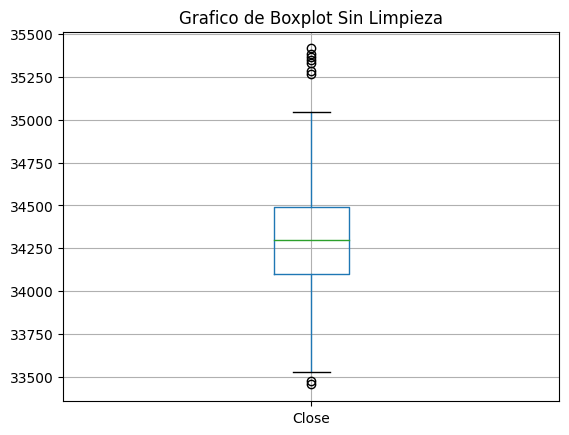

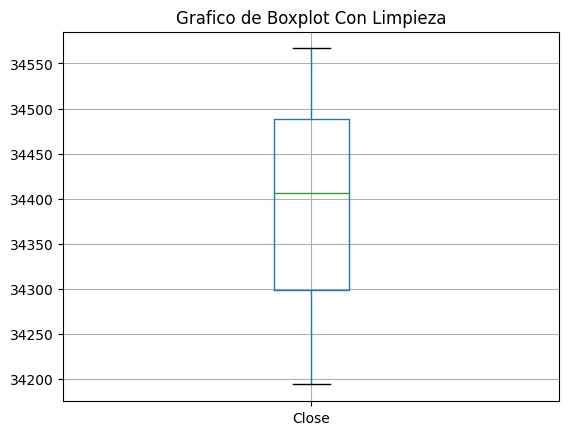

In [5]:
limpieza_datos()
df_bitcoin.boxplot(['Close'])
plt.title('Grafico de Boxplot Sin Limpieza')
plt.show()
df_bitcoin_limpio.boxplot(['Close'])
plt.title('Grafico de Boxplot Con Limpieza')
plt.show()

# Tomar decisiones

In [6]:
def tomar_decisiones():
    global df_bitcoin, precio_actual, tendencia, media_bitcoin, algoritmo_decision
    # Creo una condiciones para la toma de decisión viendo el precio_actual, la media_bitcoin y la tendencia
    if (precio_actual >= media_bitcoin) & (tendencia == 'Baja'):
        algoritmo_decision = 'Vender'
    elif (precio_actual < media_bitcoin) & (tendencia == 'Alta'):
        algoritmo_decision = 'Comprar'
    else:
        algoritmo_decision = 'Esperar'

    print('Precio Promedio Bitcoin: ', media_bitcoin)
    print('Precio Actual Bitcoin: ', precio_actual)
    print('Tendencia: ', tendencia)
    print('Decisión del algoritmo: ', algoritmo_decision)

tomar_decisiones()

Precio Promedio Bitcoin:  34393.29
Precio Actual Bitcoin:  35284.27
Tendencia:  alta
Decisión del algoritmo:  Esperar


# Visualización

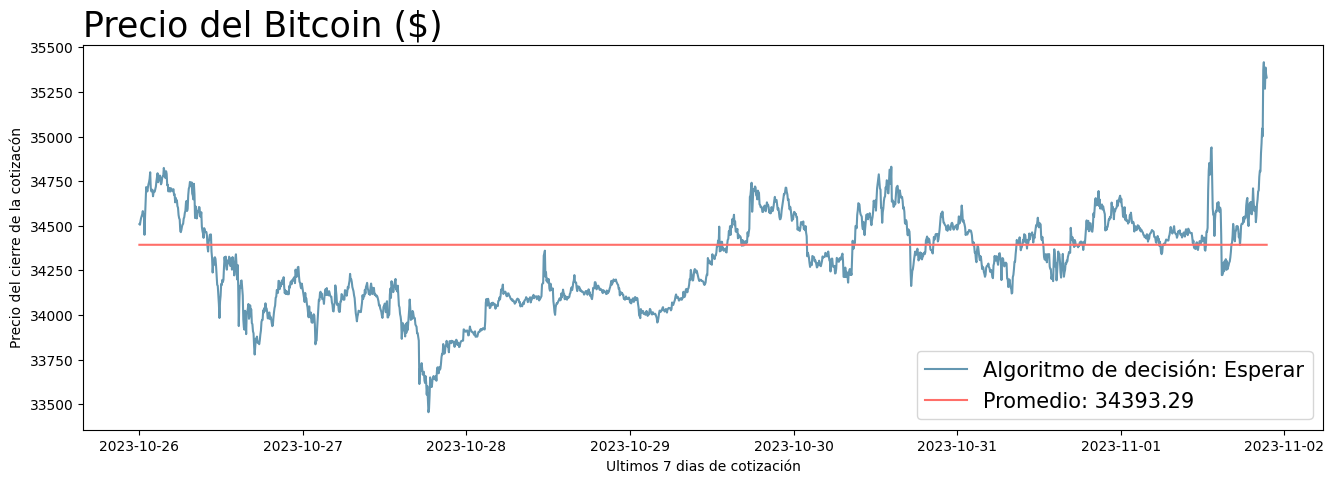

In [7]:
def visualizacion():
    global df_bitcoin, precio_actual, tendencia, media_bitcoin,  algoritmo_decision, df_bitcoin_limpio

    # Adicionamos una nueva columna (Promedio) al DataFrame original y almacenamos la variable media_bitcoin
    df_bitcoin['Promedio'] = media_bitcoin

    # Configuramos la salida del gráfico
    plt.figure(figsize = (16,5))
    # Adicionamos título
    plt.title('Precio del Bitcoin ($)', fontsize = 25 , loc = 'left')
    # Dibujamos el gráfico con los datos del índice y la columna Close del DataFrame original
    plt.plot(df_bitcoin.index, df_bitcoin['Close'], color='#6497b1')
    # Dibujamos el gráfico con los datos del índice y la columna promedio que agregamos anteriormente en el DataFrame original
    plt.plot(df_bitcoin.index, df_bitcoin['Promedio'], color='#ff6f69')
    # Usamos el método annotate() para mostrar el mensaje dentro del gráfico con la decisión calculada del algoritmo.
    # plt.annotate(algoritmo_decision, xy=(0.80, 0.10), xycoords='axes fraction', fontsize=20)

    plt.xlabel('Ultimos 7 dias de cotización')
    plt.ylabel('Precio del cierre de la cotizacón')
    legend_labels = ['Algoritmo de decisión: ' + algoritmo_decision, 'Promedio: ' + str(media_bitcoin)]
    plt.legend(legend_labels, fontsize = 15, loc='lower right')
    plt.show()

visualizacion()



# Automatización

El índice en la tabla para la posicion del BTC es:  0
El precio actual del Bitcoin en este momento es:  35284.27
La tendencia actual del bitcoin es:  alta
El promedio de precios del Bitcoin antes de la limpieza es: $ 34295.42
El promedio de precios del Bitcoin despueś de la limpieza es: $ 34393.29
Precio Promedio Bitcoin:  34393.29
Precio Actual Bitcoin:  35284.27
Tendencia:  alta
Decisión del algoritmo:  Esperar


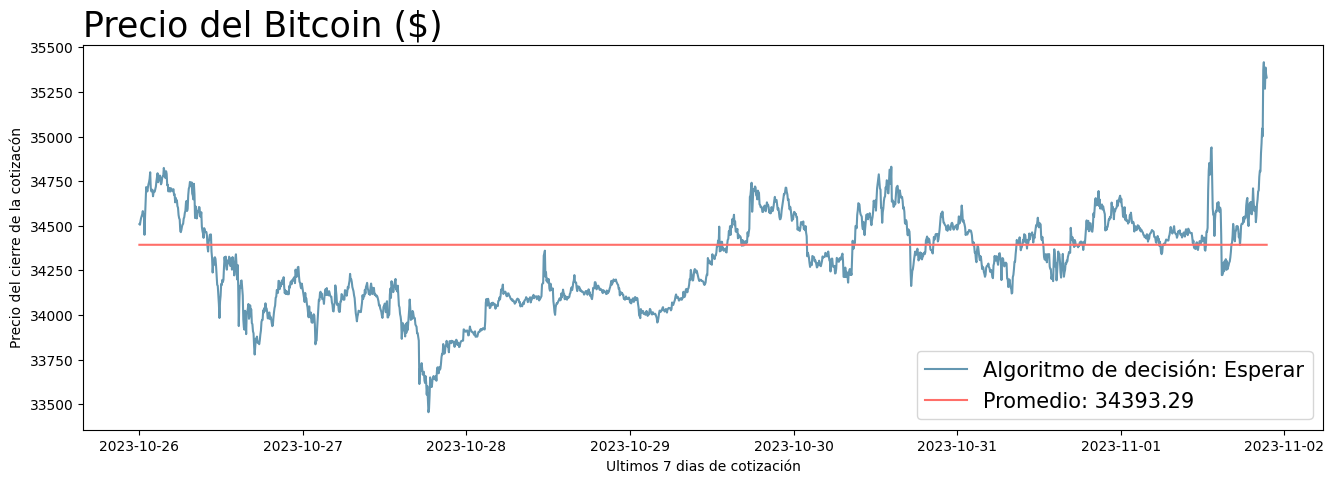

In [ ]:
# Importamos el método 'clear_output()' para borrar los resultados de la pantalla antes de imprimir un nuevo gráfico,
# y asi evitar tener más de un gráfico en la pantalla
from IPython.display import clear_output
# Importamos la biblioteca ‘time’ para interrumpir la ejecución del código cada 300 segundos es decir cada 5 minutos.
import time
# Finalmente construimos un loop infinito para ejecutar permanentemente y en intervalos de 5minutos las funciones creadas anteriormente
while True:
    clear_output()
    importar_base_bitcoin()
    extraer_tendencias()
    limpieza_datos()
    tomar_decisiones()
    visualizacion()
    time.sleep(300)